# Minimum covering Wasserstein ball - Fixed support experiment 

### Load libraries

In [1]:
import numpy as np
import cvxpy as cp
from itertools import product
import matplotlib.pyplot as plt

### Load Dataset: MINST 8x8 pixels

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

### Load $\hat{p}s$

In [3]:
# select k
K = 15

# select cifre to analyze
digit = 3

# Save p_k
p_k = [np.array(digits.images[k].flatten())/sum(np.array(digits.images[k].flatten())) for k in np.where(digits.target == digit)[0][0:K]]

# Define support for T
N = len(p_k[0])

### Create cost function matrix (for now we use $l$-2 norm, probably not very efficient)

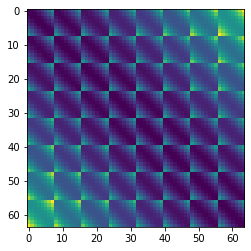

In [4]:
# Define support for xi
N_euc = int(np.sqrt(N))

# Create cost matrix (l-2 norm used for the moment)
c = np.zeros((N, N))
for i, mi in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
    for j, mj in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
        c[i, j] = np.linalg.norm(np.array(mi)- np.array(mj), 2)**2 # l-2 norm
        #c[i, j] = np.linalg.norm(np.array(mi)- np.array(mj), 1) # l-1 norm

# Plot
plt.imshow(c)

## Define optmization program in CVXPY

In [5]:
# Dec Var
T = [cp.Variable((N, N)) for k in range(K)]
epsilon = cp.Variable((1, 1))
p = cp.Variable((N))

# Obj
obj = cp.Minimize(epsilon)

cons = []
# Cons
for k in range(K):
    cons.append(T[k] >= 0)
    #cons.append(sum(sum(cp.multiply(T[k], c))) <= epsilon)
    cons.append(cp.trace(c.T@T[k]) <= epsilon)
    cons.append(T[k]@np.ones(N) == p)
    cons.append(T[k].T@np.ones(N) == p_k[k])

# Solve program
problem = cp.Problem(obj, cons)
problem.solve(solver = cp.SCIPY, scipy_options={"method": "highs"})

0.7290014976847722

### Create 2-D render of the optimal distribution

In [6]:
p_opt = [p.value[i*N_euc:N_euc*(i + 1)] for i in range(N_euc)]

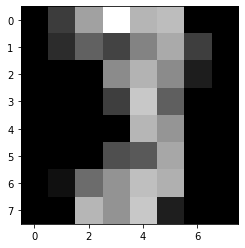

In [7]:
plt.gray()
plt.imshow(p_opt)

### Compare with arithmetic mean of pixels

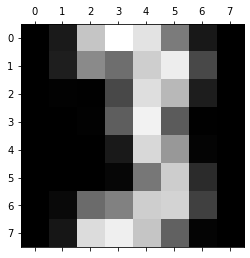

In [8]:
digit_mean = p_k[0].reshape((N_euc, N_euc))
for i in range(1,k):
    digit_mean +=p_k[i].reshape((N_euc, N_euc))

plt.matshow(digit_mean)

# Experiment with shifted digits 16x16 pixels

## Select number of samples k, create a random shift for each sample

In [76]:
# select k
K = 15

# select cifre to analyze
digit = 0

# Save p_k
p_k = []

# Loop in number of digits
for k in np.where(digits.target == digit)[0][0:K]:
    
    # Create a random shift for each sample
    shift = np.round(4 - 8*np.random.rand(2))
    
    # Create the new image with the shift in 16x16 pixel array
    new_digits = np.zeros((16, 16))
    new_digits[4 + int(shift[0]): 12 + int(shift[0]), 4 + int(shift[1]):12 + int(shift[1])] = digits.images[k]
    p_k.append(np.array(new_digits.flatten())/sum(np.array(new_digits.flatten())))
    
# Define support for T
N = len(p_k[0])

## Create cost function matrix

In [77]:
# Define support for xi
N_euc = int(np.sqrt(N))

# Create cost matrix (l-2 norm used for the moment)
c = np.zeros((N, N))
for i, mi in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
    for j, mj in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
        c[i, j] = np.linalg.norm(np.array(mi)- np.array(mj), 2)**2 # l-2 norm
        #c[i, j] = np.linalg.norm(np.array(mi)- np.array(mj), 1) # l-1 norm

## Define optimization program

In [78]:
# Dec Var
T = [cp.Variable((N, N)) for k in range(K)]
epsilon = cp.Variable((1, 1))
p = cp.Variable((N))

# Obj
obj = cp.Minimize(epsilon)

# Cons
cons = []
for k in range(K):
    cons.append(T[k] >= 0)
    #cons.append(sum(sum(cp.multiply(T[k], c))) <= epsilon)
    cons.append(cp.trace(c.T@T[k]) <= epsilon)
    cons.append(T[k]@np.ones(N) == p)
    cons.append(T[k].T@np.ones(N) == p_k[k])

# Solve program
problem = cp.Problem(obj, cons)
problem.solve(solver = cp.SCIPY, scipy_options={"method": "highs"})

17.090929412726243

## Recover and render P_opt

In [79]:
p_opt = [p.value[i*N_euc:N_euc*(i + 1)] for i in range(N_euc)]

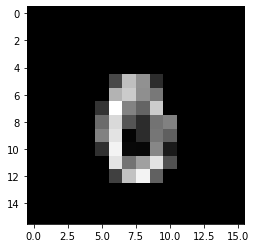

In [80]:
plt.gray()
plt.imshow(p_opt)

## Create and render an arithmetic mean case, for comparison

In [81]:
digit_mean = p_k[0].reshape((N_euc, N_euc)).copy()
for i in range(1,K):
    digit_mean += p_k[i].reshape((N_euc, N_euc))

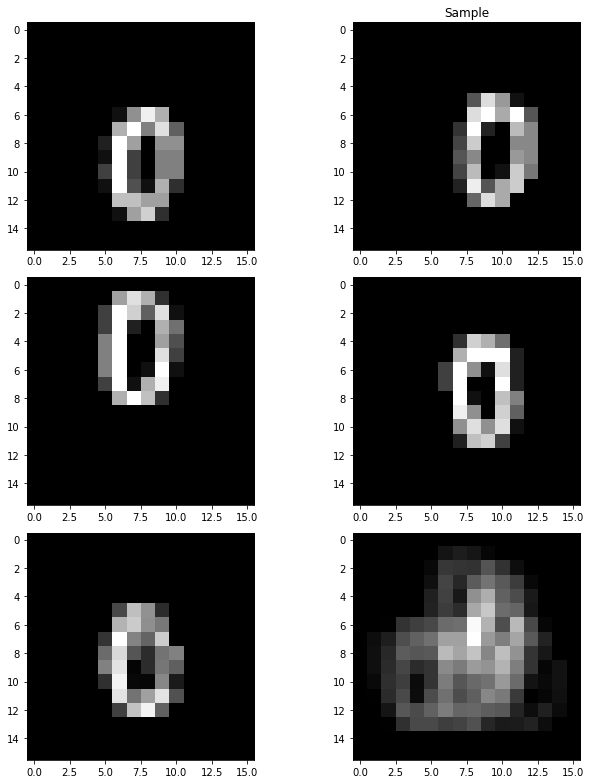

In [82]:
fig, ax = plt.subplots(3, 2, figsize = (10, 11))

for i in range(2):
    ax[i, 0].imshow(p_k[2*i+1].reshape((N_euc, N_euc)))
    ax[i, 1].imshow(p_k[2*i].reshape((N_euc, N_euc)))
    
    
ax[2, 0].imshow(p_opt)
ax[2, 1].imshow(digit_mean)

ax[0, 1].set_title('Sample')
plt.tight_layout()
#plt.savefig('lol.pdf')

# Data poisoning

In [93]:
# select k
K = 15

# select cifre to analyze
digit = 0

# Save p_k
p_k = []

shift = (0, -4) 
k = np.where(digits.target == digit)[0][0]
new_digits = np.zeros((16, 16))
new_digits[4 + int(shift[0]): 12 + int(shift[0]), 4 + int(shift[1]):12 + int(shift[1])] = digits.images[k]
p_k.append(np.array(new_digits.flatten())/sum(np.array(new_digits.flatten())))

# Loop in number of digits
for k in np.where(digits.target == digit)[0][1:K]:
    
    # Create a random shift for each sample
    shift = (0, 4) 
    
    # Create the new image with the shift in 16x16 pixel array
    new_digits = np.zeros((16, 16))
    new_digits[4 + int(shift[0]): 12 + int(shift[0]), 4 + int(shift[1]):12 + int(shift[1])] = digits.images[k]
    p_k.append(np.array(new_digits.flatten())/sum(np.array(new_digits.flatten())))




# Define support for T
N = len(p_k[0])

In [94]:
# Define support for xi
N_euc = int(np.sqrt(N))

# Create cost matrix (l-2 norm used for the moment)
c = np.zeros((N, N))
for i, mi in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
    for j, mj in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
        c[i, j] = np.linalg.norm(np.array(mi)- np.array(mj), 2)**2 # l-2 norm

In [95]:
# Dec Var
T = [cp.Variable((N, N)) for k in range(K)]
epsilon = cp.Variable((1, 1))
p = cp.Variable((N))

# Obj
obj = cp.Minimize(epsilon)

# Cons
cons = []
for k in range(K):
    cons.append(T[k] >= 0)
    #cons.append(sum(sum(cp.multiply(T[k], c))) <= epsilon)
    cons.append(cp.trace(c.T@T[k]) <= epsilon)
    cons.append(T[k]@np.ones(N) == p)
    cons.append(T[k].T@np.ones(N) == p_k[k])

# Solve program
problem = cp.Problem(obj, cons)
problem.solve(solver = cp.SCIPY, scipy_options={"method": "highs"})

16.426322320459136

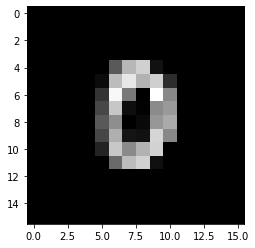

In [97]:
p_opt = p.value.reshape(N_euc, N_euc)
plt.gray()
plt.imshow(p_opt)

In [98]:
digit_mean = p_k[0].reshape((N_euc, N_euc)).copy()
for i in range(1,K):
    digit_mean += p_k[i].reshape((N_euc, N_euc))

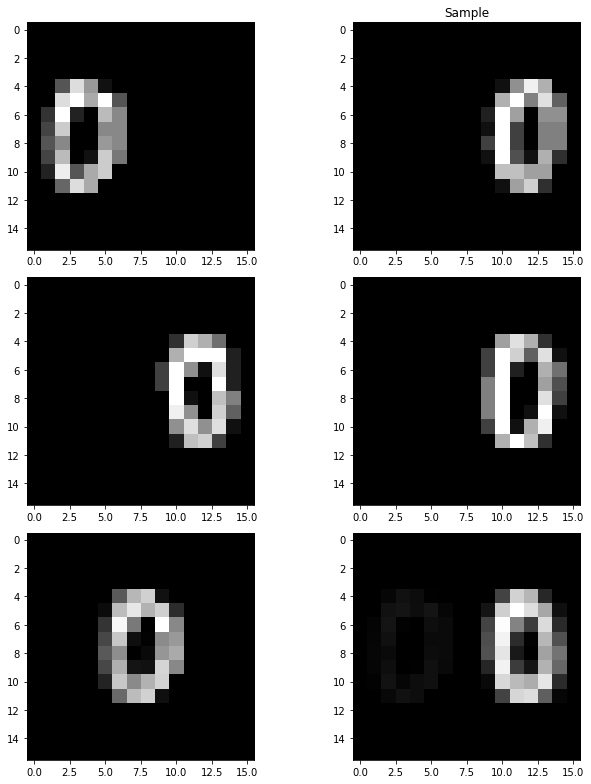

In [100]:
fig, ax = plt.subplots(3, 2, figsize = (10, 11))

for i in range(2):
    ax[i, 1].imshow(p_k[2*i+1].reshape((N_euc, N_euc)))
    ax[i, 0].imshow(p_k[2*i].reshape((N_euc, N_euc)))
    
    
ax[2, 0].imshow(p_opt)
ax[2, 1].imshow(digit_mean)

ax[0, 1].set_title('Sample')
plt.tight_layout()